In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import math
import matplotlib.pyplot as plt

In [2]:
def display_bgr2rgp(img):
    rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.imshow(rgb_img)
    plt.show()
    
def preprocess(img, factor=2):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = Image.fromarray(img)
    enhancer = ImageEnhance.Sharpness(img).enhance(factor)
    if gray.std() < 30:
        enhancer = ImageEnhance.Contrast(enhancer).enhance(factor)
    return np.array(enhancer)

def cell_in_same_row(c1, c2):
    c1_center = c1[1] + c1[3] / 2
    c2_bottom = c2[1] + c2[3]
    c2_top = c2[1]
    return c2_top < c1_center < c2_bottom

def avg_height_of_center(row):
    centers = [y + h / 2 for x, y, w, h in row]
    return sum(centers) / len(centers)

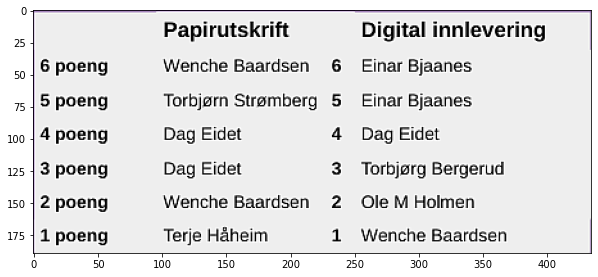

In [3]:
img_path = "images/19.png"

img = cv.imread(img_path)
img = preprocess(img, 2)

display_bgr2rgp(img)

In [4]:
def binarilize(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (3,3), 0, 0)
    thresh = cv.adaptiveThreshold(~blur,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,5,-2,)
    # remove border noise
    cv.rectangle(thresh, (0,0), thresh.shape[::-1], 0, 3)
    return thresh

def remove_border(thresh, REMOVE_SCALE=3):
    # get vertical and horizontal lines and remove them
    vertical = horizontal = thresh.copy()
    img_height, img_width = horizontal.shape
    
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(img_width / REMOVE_SCALE), 1))
    horizontally_opened = cv.morphologyEx(thresh, cv.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, int(img_height / REMOVE_SCALE)))
    vertically_opened = cv.morphologyEx(thresh, cv.MORPH_OPEN, vertical_kernel)
    both = horizontally_opened + vertically_opened
    both = cv.dilate(both, cv.getStructuringElement(cv.MORPH_RECT, (5,5)))
    
    borderless = thresh - both

    return borderless

def check_combine_column(a, b, MIN_COLUMN_SPACE=12):
    #x2 > x1
    x1, y1, w1, h1 = a
    x2, y2, w2, h2 = b
    
    col_space = x2 - (x1 + w1) + 1
    if col_space < MIN_COLUMN_SPACE:
        new_rect = (x1, min(y1, y2), w2+x2-x1+1, max(y1+h1, y2+h2) - min(y1,y2)+ 1)
        return new_rect
    else:
        return False
    
def check_combine_row(a, b, MIN_ROW_SPACE=12):
    #y2 > y1
    x1, y1, w1, h1 = a
    x2, y2, w2, h2 = b
    
    row_space = y2 - (y1 + h1) + 1
    if row_space < MIN_ROW_SPACE:
        new_rect = (min(x1,x2), y1, max(x1+w1, x2+w2) - min(x1,x2) + 1, h2+y2-y1+1)
        return new_rect
    else:
        return False
    
def reduce_col(rects, MIN_COLUMN_SPACE=12):
    cursor = len(rects) - 1
    while cursor > 0:
        last = rects[cursor]
        next_last = rects[cursor-1] if rects[cursor-1] else None
        if next_last:
            check = check_combine_column(last, next_last, MIN_COLUMN_SPACE)
            if check != False:
                rects.pop(cursor)
                rects.pop(cursor - 1)
                rects.insert(cursor-1, check)
        cursor -= 1
    return rects

def reduce_row(rects, MIN_ROW_SPACE=12):
    cursor = len(rects) - 1
    while cursor > 0:
        last = rects[cursor]
        next_last = rects[cursor-1] if rects[cursor-1] else None
        if next_last:
            check = check_combine_row(last, next_last, MIN_ROW_SPACE)
            if check != False:
                rects.pop(cursor)
                rects.pop(cursor - 1)
                rects.insert(cursor-1, check)
        cursor -= 1
    return rects


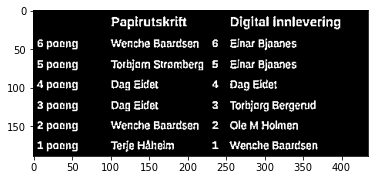

In [5]:
binimg = binarilize(img)
plt.imshow(binimg, cmap='gray')
plt.show()

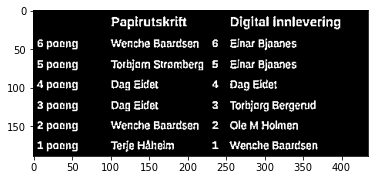

In [6]:
borderless = remove_border(binimg)
plt.imshow(borderless, cmap='gray')
plt.show()

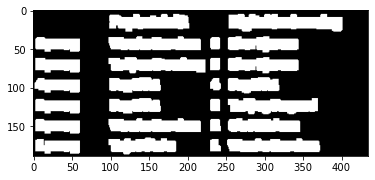

In [8]:
kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
dilated = cv.dilate(borderless, kernel, iterations=3)
plt.imshow(dilated, cmap='gray')
plt.show()

In [9]:
contours, hierarchy = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
len(contours)

26

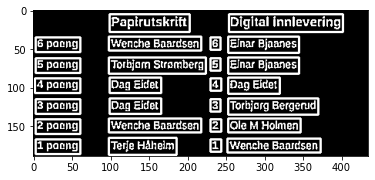

In [11]:
bnd = [cv.boundingRect(c) for c in contours]
test = binimg.copy()
for box in bnd:
    cv.rectangle(test, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), 255, 2)

plt.imshow(test, cmap='gray')
plt.show()